In [50]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

class CrossAttention(nn.Module):
    def __init__(self, d_in, d_out_kq, d_out_v):
        super(CrossAttention, self).__init__()
        self.key_proj = nn.Linear(d_in, d_out_kq)
        self.query_proj = nn.Linear(d_in, d_out_kq)
        self.value_proj = nn.Linear(d_in, d_out_v)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, latent):
        keys = self.key_proj(x)
        queries = self.query_proj(latent)
        values = self.value_proj(x)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_probs = self.softmax(attention_scores)

        attended_values = torch.matmul(attention_probs, values)
        return attended_values


class LatentTransformer(nn.Module):
    def __init__(self, latent_dim, num_heads, num_layers, embed_dim):
        super(LatentTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, latent):
        latent = latent.permute(1, 0, 2)
        latent = self.transformer(latent)
        return latent.permute(1, 0, 2)


class Averaging(nn.Module):
    def forward(self, latent):
        return latent.mean(dim=1)


class Perceiver(nn.Module):
    def __init__(self, input_dim, latent_dim, embed_dim, num_heads, num_layers, num_classes):
        super(Perceiver, self).__init__()
        self.input_proj = nn.Linear(input_dim, embed_dim)
        self.latents = nn.Parameter(torch.randn(1, latent_dim, embed_dim))

        self.cross_attention = CrossAttention(d_in=embed_dim, d_out_kq=embed_dim, d_out_v=embed_dim)
        self.latent_transformer = LatentTransformer(latent_dim=latent_dim, num_heads=num_heads,
                                                    num_layers=num_layers, embed_dim=embed_dim)

        self.averaging = Averaging()
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.input_proj(x)
        latent = self.latents.repeat(batch_size, 1, 1)
        latent = self.cross_attention(x, latent)
        latent = self.latent_transformer(latent)
        latent_avg = self.averaging(latent)
        logits = self.classifier(latent_avg)
        return logits


In [51]:
# 데이터셋 정의
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        input_ids = encoding['input_ids'].squeeze(0)

        return input_ids, label

# 데이터 준비
def prepare_data(batch_size=32, max_length=128):
    dataset = load_dataset("ag_news")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    label_encoder = LabelEncoder()
    train_labels = label_encoder.fit_transform(dataset['train']['label'])
    test_labels = label_encoder.transform(dataset['test']['label'])

    train_dataset = AGNewsDataset(dataset['train']['text'], train_labels, tokenizer, max_length)
    test_dataset = AGNewsDataset(dataset['test']['text'], test_labels, tokenizer, max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader, len(label_encoder.classes_), tokenizer, label_encoder

In [52]:
# 평가 함수
def evaluate_model(model, test_loader, device, criterion=None, return_loss=False):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            outputs = model(inputs)

            if criterion:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    if return_loss:
        return total_loss / len(test_loader)

    return all_labels, all_preds


In [53]:
# 학습 함수
def train_model(model, train_loader, test_loader, num_epochs, device, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_losses.append(total_train_loss / len(train_loader))

        test_loss = evaluate_model(model, test_loader, device, criterion, return_loss=True)
        test_losses.append(test_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

# 각 클래스별 정확도 계산
def evaluate_class_wise_accuracy(labels, preds, num_classes):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for label, pred in zip(labels, preds):
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1

    for i in range(num_classes):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Class {i} Accuracy: {accuracy:.2f}%")



In [54]:

# 시각화 함수
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Test Losses')
    plt.show()

# Confusion Matrix 출력
def plot_confusion_matrix(labels, preds, label_encoder):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

/home/youlee/perceiver/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Test Accuracy: 25.00%
Epoch 1, Train Loss: 1.3899, Test Loss: 1.3879
Test Accuracy: 25.00%
Epoch 2, Train Loss: 1.3875, Test Loss: 1.3866
Test Accuracy: 25.20%
Epoch 3, Train Loss: 1.3873, Test Loss: 1.3862
Test Accuracy: 25.00%
Epoch 4, Train Loss: 1.3871, Test Loss: 1.3865
Test Accuracy: 25.00%
Epoch 5, Train Loss: 1.3868, Test Loss: 1.3867
Test Accuracy: 25.00%
Epoch 6, Train Loss: 1.3867, Test Loss: 1.3865
Test Accuracy: 25.25%
Epoch 7, Train Loss: 1.3867, Test Loss: 1.3861
Test Accuracy: 26.30%
Epoch 8, Train Loss: 1.3866, Test Loss: 1.3856
Test Accuracy: 25.00%
Epoch 9, Train Loss: 1.3866, Test Loss: 1.3860
Test Accuracy: 25.51%
Epoch 10, Train Loss: 1.3864, Test Loss: 1.3858


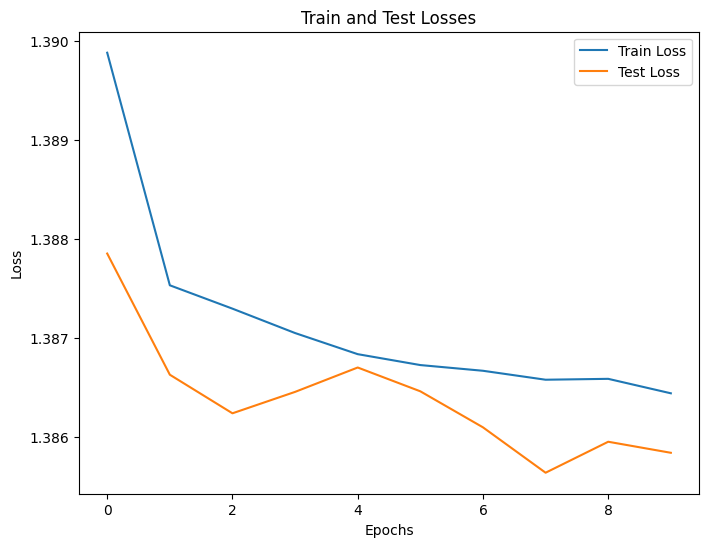

Test Accuracy: 25.51%


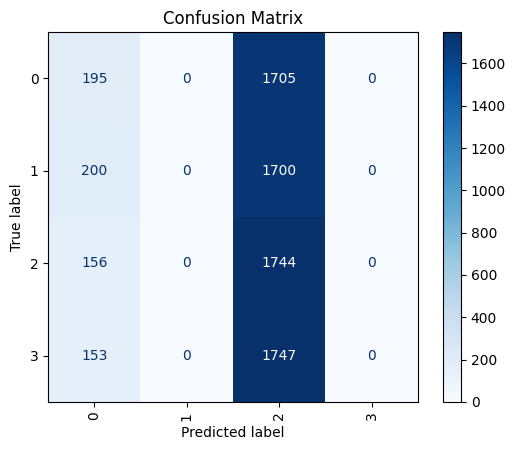

In [55]:
# 실행
def main():
    input_dim = 128
    latent_dim = 16
    embed_dim = 64
    num_heads = 4
    num_layers = 2
    num_classes = 4
    num_epochs = 10
    batch_size = 32
    max_length = 128
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, test_loader, num_classes, tokenizer, label_encoder = prepare_data(batch_size, max_length)

    model = Perceiver(input_dim=max_length, latent_dim=latent_dim, embed_dim=embed_dim,
                      num_heads=num_heads, num_layers=num_layers, num_classes=num_classes)
    model.to(device)

    train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, device)
    plot_losses(train_losses, test_losses)

    labels, preds = evaluate_model(model, test_loader, device)
    plot_confusion_matrix(labels, preds, label_encoder)

if __name__ == "__main__":
    main()

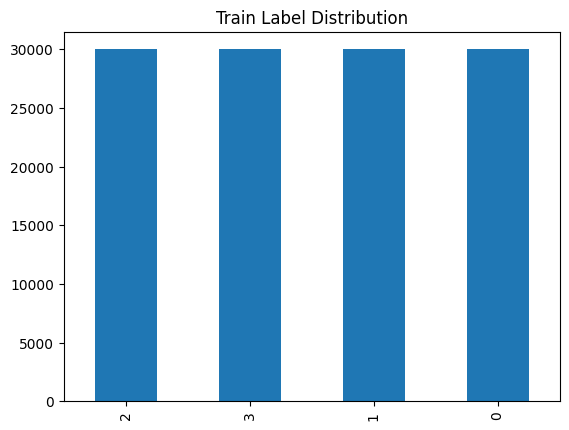

In [56]:
# 클래스 분포 확인
import pandas as pd

dataset = load_dataset("ag_news")
train_labels = dataset['train']['label']
train_label_distribution = pd.Series(train_labels).value_counts()

train_label_distribution.plot(kind='bar', title="Train Label Distribution")
plt.show()

In [57]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
